# ANFIS for Chaotic Time Series, using Fuzzy C-Means and Linear Regression

## About this notebook

#### Authors:
Gabriela Sandoval
Héctor Camarillo

#### Definition:
Based on the paper from Jyh-Shing R Jang, "ANFIS: adaptive-network-based fuzzy inference
systems", where an application for predicting a chaotic time series representation is described, we addepted the idea to python

## Importing everything

These are every imports we will be needing

In [9]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import skfuzzy as fuzz
%matplotlib inline
from sklearn import linear_model

## Defining Mackey Glass Chaotic Time series

We need to generate a Chaotic time series in order to predict future values. In the paper by Jang, a Mackey Glass time series is used. Therefore, the next cells contains every function to generate it. We based our code in the Matlab code by Marco Cococcioni, that is also adapted from the one developed by Roger Jang in C. We addapted indexes since Matlab arrays start in 1, and python's in 0. We also got rid of several if conditions regarding a tao value close to cero. Therefore, for those values it is very likely that the code won´t work.  
First two functions are needed:

In [10]:
def mackeyglass_eq(x_t, x_t_minus_tau,a,b):
    x_dot=-b*x_t+a*x_t_minus_tau/(1+np.power(x_t_minus_tau,10))
    return x_dot

In [11]:
def mackeyglass_rk4(x_t, x_t_minus_tau,deltaT,a,b):
    k1=deltaT*mackeyglass_eq(x_t,x_t_minus_tau,a,b)
    k2=deltaT*mackeyglass_eq(x_t+0.5*k1,x_t_minus_tau,a,b)
    k3=deltaT*mackeyglass_eq(x_t+0.5*k2,x_t_minus_tau,a,b)
    k4=deltaT*mackeyglass_eq(x_t+k3,x_t_minus_tau,a,b)
    x_t_plus_deltat = x_t+k1/6+k2/3+k3/3+k4/6
    return x_t_plus_deltat

Then, all the parameters are set, and kept in X and T. T is the time, and X is the value of the chaotic time series

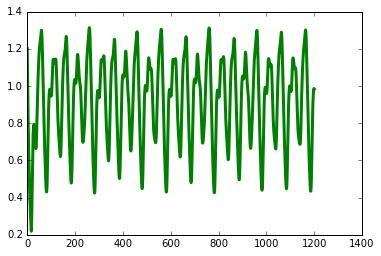

In [12]:
#Setting the parameters
a=0.2
b=0.1
tau=17
x0=1.2
deltaT=0.1
nSamples=12000
interval=1
time=0

#Initialization of variables
historyLength=mt.floor(tau/deltaT)
historyLength=int(historyLength)
x_history=np.zeros(historyLength)
x_t=x0
X=np.zeros(nSamples)
T=np.zeros(nSamples)
index=0
x_t=x0

#Starting a for cicle to obtain every point of the function
for i in range(0,nSamples):
    X[i]=x_t
    x_t_minus_tau=x_history[index]
    x_t_plus_deltat=mackeyglass_rk4(x_t,x_t_minus_tau,deltaT,a,b)
    x_history[index]=x_t_plus_deltat
    index=(index+1)%(historyLength)
    time=time+deltaT
    T[i]=time
    x_t=x_t_plus_deltat
    
#Plotting the result
plt.plot(T,X,c='g', linewidth=3)
plt.show()

## ANFIS

Having the data, now we can feed it to the ANFIS. An ANFIS as proposed by Jang consists of 5 layers. The first layer computes the membership funtions of the inputs. The second, the activation of the rules by multiplying the outputs of the previous layer. Third layer is a normalization process. Fourth layer is a neural based layer, having adaptive weights. This particular layer we changed it a bit, by making it a linear regression layer. And last layer, is a sumation of the previous layer.  

First things first. The input for the anfis consists of five values. Four inputs, regarding a time and the values previous to it. The fifth value is the expected value, which is the next value. So:

### Preparing the input data

In [13]:
#Setting the separation betwen time
d1=18
d2=12
d3=6
d4=0
d5=6

#Defining the number of samples to train the anfis
nTraining=1000

#Generating every sample
inputArray=np.zeros(5)
previousX=np.zeros(d1) #18 because it is the example from the paper
allX=np.concatenate((previousX,X)) #Every Sample
ti=118
tiOriginal=ti
for i in range(0,nTraining):
    #i is the sample
    inputI=np.array([allX[ti-d1],allX[ti-d2],allX[ti-d3],allX[ti-d4],allX[ti+d5]])
    inputArray=np.vstack((inputArray, inputI))
    ti=ti+1
onlyInputs= inputArray[1::,0:4]

### First Layer, fuzzyfing each input

Having the inputs ready, we apply fuzzy c-means for each input, considering two clusters, like Jang paper

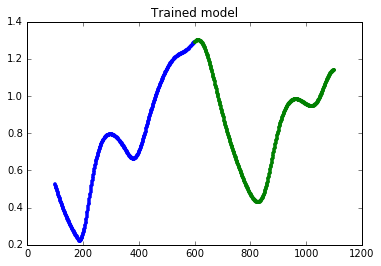

In [14]:
inputs1st=onlyInputs[:,0]
nsize=np.size(inputs1st)
nClusters=2

xpts=np.linspace(0-d1+tiOriginal, nsize-d1+tiOriginal,nsize)
ypts=inputs1st
alldata = np.vstack((xpts, ypts))

cntr1, membership1st, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    alldata, nClusters, 2, error=0.07, maxiter=100)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(nClusters):
    ax2.plot(alldata[0, membership1st.argmax(axis=0) == j],
             alldata[1, membership1st.argmax(axis=0) == j], '.',
             label='series ' + str(j))
#ax2.legend()

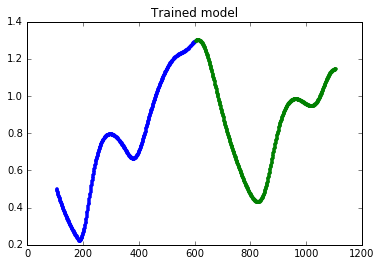

In [15]:
inputs2nd=onlyInputs[:,1]
nsize=np.size(inputs2nd)
nClusters=2

xpts=np.linspace(0-d2+tiOriginal, nsize-d2+tiOriginal,nsize)
ypts=inputs2nd
alldata = np.vstack((xpts, ypts))

cntr2, membership2nd, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    alldata, nClusters, 2, error=0.07, maxiter=100)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(nClusters):
    ax2.plot(alldata[0, membership2nd.argmax(axis=0) == j],
             alldata[1, membership2nd.argmax(axis=0) == j], '.',
             label='series ' + str(j))
#ax2.legend()

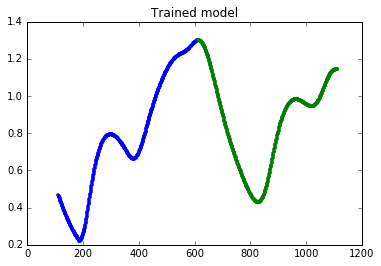

In [16]:
inputs3rd=onlyInputs[:,2]
nsize=np.size(inputs3rd)
nClusters=2

xpts=np.linspace(0-d3+tiOriginal, nsize-d3+tiOriginal,nsize)
ypts=inputs3rd
alldata = np.vstack((xpts, ypts))

cntr3, membership3rd, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    alldata, nClusters, 2, error=0.07, maxiter=100)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(nClusters):
    ax2.plot(alldata[0, membership3rd.argmax(axis=0) == j],
             alldata[1, membership3rd.argmax(axis=0) == j], '.',
             label='series ' + str(j))
#ax2.legend()

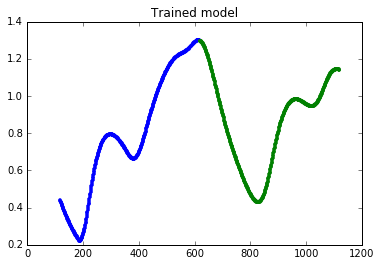

In [17]:
inputs4th=onlyInputs[:,3]
nsize=np.size(inputs4th)
nClusters=2

xpts=np.linspace(0-d4+tiOriginal, nsize-d4+tiOriginal,nsize)
ypts=inputs4th
alldata = np.vstack((xpts, ypts))

cntr4, membership4th, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    alldata, nClusters, 2, error=0.07, maxiter=100)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(nClusters):
    ax2.plot(alldata[0, membership4th.argmax(axis=0) == j],
             alldata[1, membership4th.argmax(axis=0) == j], '.',
             label='series ' + str(j))
#ax2.legend()

### Second Layer

Setting the rules obtained from the fuzzy clusters

In [18]:
pi1=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi2=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi3=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi4=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))
pi5=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi6=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi7=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi8=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))
pi9=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi10=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi11=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi12=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))
pi13=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi14=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi15=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi16=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))


### Third Layer

Only a normalization process

In [19]:
piSum=pi1+pi2+pi3+pi4+pi5+pi6+pi7+pi8+pi9+pi10+pi11+pi12+pi13+pi14+pi15+pi16

w1=np.divide(pi1,piSum)
w2=np.divide(pi2,piSum)
w3=np.divide(pi3,piSum)
w4=np.divide(pi4,piSum)
w5=np.divide(pi5,piSum)
w6=np.divide(pi6,piSum)
w7=np.divide(pi7,piSum)
w8=np.divide(pi8,piSum)
w9=np.divide(pi9,piSum)
w10=np.divide(pi10,piSum)
w11=np.divide(pi11,piSum)
w12=np.divide(pi12,piSum)
w13=np.divide(pi13,piSum)
w14=np.divide(pi14,piSum)
w15=np.divide(pi15,piSum)
w16=np.divide(pi16,piSum)

### Fourth Layer

Our adapted linear regression layer. First we need the target values to train this layer, and then only use python functions

In [20]:
#The target Values
expectedValue=inputArray[1::,4:5]

#Inputs for every last layer, adding a bias, as in a neural network
bias=np.ones((1,nTraining))
biasedInputs=np.vstack((onlyInputs.T,bias))
biasedInputs=biasedInputs.T

In [21]:
#Square 1

regresion1=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w1.T)
expectedValueRegresion=expectedValueRegresion.T
regresion1.fit(biasedInputs,expectedValueRegresion)
coeff1=regresion1.coef_
wf1=regresion1.predict(biasedInputs)
error1=expectedValueRegresion-wf1

In [22]:
#Square 2

regresion2=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w2.T)
expectedValueRegresion=expectedValueRegresion.T
regresion2.fit(biasedInputs,expectedValueRegresion)
coeff2=regresion2.coef_
wf2=regresion2.predict(biasedInputs)
error2=expectedValueRegresion-wf2

In [23]:
#Square 3

regresion3=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w3.T)
expectedValueRegresion=expectedValueRegresion.T
regresion3.fit(biasedInputs,expectedValueRegresion)
coeff3=regresion3.coef_
wf3=regresion3.predict(biasedInputs)
error3=expectedValueRegresion-wf3

In [24]:
#Square 4

regresion4=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w4.T)
expectedValueRegresion=expectedValueRegresion.T
regresion4.fit(biasedInputs,expectedValueRegresion)
coeff4=regresion4.coef_
wf4=regresion4.predict(biasedInputs)
error4=expectedValueRegresion-wf4

In [25]:
#Square 5

regresion5=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w5.T)
expectedValueRegresion=expectedValueRegresion.T
regresion5.fit(biasedInputs,expectedValueRegresion)
coeff5=regresion5.coef_
wf5=regresion5.predict(biasedInputs)
error5=expectedValueRegresion-wf5

In [26]:
#Square 6

regresion6=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w6.T)
expectedValueRegresion=expectedValueRegresion.T
regresion6.fit(biasedInputs,expectedValueRegresion)
coeff6=regresion6.coef_
wf6=regresion6.predict(biasedInputs)
error6=expectedValueRegresion-wf6

In [27]:
#Square 7

regresion7=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w7.T)
expectedValueRegresion=expectedValueRegresion.T
regresion7.fit(biasedInputs,expectedValueRegresion)
coeff7=regresion7.coef_
wf7=regresion7.predict(biasedInputs)
error7=expectedValueRegresion-wf7

In [28]:
#Square 8

regresion8=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w8.T)
expectedValueRegresion=expectedValueRegresion.T
regresion8.fit(biasedInputs,expectedValueRegresion)
coeff8=regresion8.coef_
wf8=regresion8.predict(biasedInputs)
error8=expectedValueRegresion-wf8

In [29]:
#Square 9

regresion9=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w9.T)
expectedValueRegresion=expectedValueRegresion.T
regresion9.fit(biasedInputs,expectedValueRegresion)
coeff9=regresion9.coef_
wf9=regresion9.predict(biasedInputs)
error9=expectedValueRegresion-wf9

In [30]:
#Square 10

regresion10=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w10.T)
expectedValueRegresion=expectedValueRegresion.T
regresion10.fit(biasedInputs,expectedValueRegresion)
coeff10=regresion10.coef_
wf10=regresion10.predict(biasedInputs)
error10=expectedValueRegresion-wf10

In [31]:
#Square 11

regresion11=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w11.T)
expectedValueRegresion=expectedValueRegresion.T
regresion11.fit(biasedInputs,expectedValueRegresion)
coeff11=regresion11.coef_
wf11=regresion11.predict(biasedInputs)
error11=expectedValueRegresion-wf11

In [32]:
#Square 12

regresion12=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w12.T)
expectedValueRegresion=expectedValueRegresion.T
regresion12.fit(biasedInputs,expectedValueRegresion)
coeff12=regresion12.coef_
wf12=regresion12.predict(biasedInputs)
error12=expectedValueRegresion-wf12

In [33]:
#Square 13

regresion13=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w13.T)
expectedValueRegresion=expectedValueRegresion.T
regresion13.fit(biasedInputs,expectedValueRegresion)
coeff13=regresion13.coef_
wf13=regresion13.predict(biasedInputs)
error13=expectedValueRegresion-wf13

In [34]:
#Square 14

regresion14=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w14.T)
expectedValueRegresion=expectedValueRegresion.T
regresion14.fit(biasedInputs,expectedValueRegresion)
coeff14=regresion14.coef_
wf14=regresion14.predict(biasedInputs)
error14=expectedValueRegresion-wf14

In [35]:
#Square 15

regresion15=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w15.T)
expectedValueRegresion=expectedValueRegresion.T
regresion15.fit(biasedInputs,expectedValueRegresion)
coeff15=regresion15.coef_
wf15=regresion15.predict(biasedInputs)
error15=expectedValueRegresion-wf15

In [36]:
#Square 16

regresion16=linear_model.LinearRegression()
expectedValueRegresion=np.multiply(expectedValue.T,w16.T)
expectedValueRegresion=expectedValueRegresion.T
regresion16.fit(biasedInputs,expectedValueRegresion)
coeff16=regresion16.coef_
wf16=regresion16.predict(biasedInputs)
error16=expectedValueRegresion-wf16

### Fifth Layer

And at last, the last layer and final output of the ANFIS

In [37]:
finalOutput=wf1+wf2+wf3+wf4+wf5+wf6+wf7+wf8+wf9+wf10+wf11+wf12+wf13+wf14+wf15+wf16

### Plotting ANFIS aproximation using same training data

Well, now we need to know how well the training went, by plotting original and ANFIS data

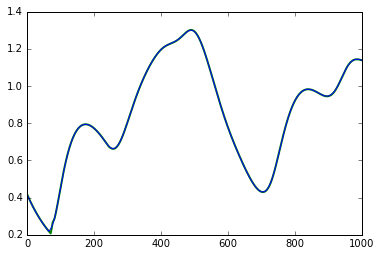

In [38]:
## Plotting Both
xpts=np.linspace(0, nTraining,nTraining)
ypts=finalOutput
plt.plot(xpts,ypts,c='g', linewidth=2)
ypts=expectedValue
plt.plot(xpts,ypts,c='b', linewidth=1)
plt.show()

## Testing the ANFIS with different data

It went great, but now the challenging part. Feeding the ANFIS with new data, not used in training, and a large number of inputs. So first we prepare the inputs:

In [39]:
## Getting the data
inputArray=np.zeros(5)
previousX=np.zeros(d1)
allX=np.concatenate((previousX,X))
ti=0
tiOriginal=ti
for i in range(0,10000):
    inputI=np.array([allX[ti-d1],allX[ti-d2],allX[ti-d3],allX[ti-d4],allX[ti+d5]])
    inputArray=np.vstack((inputArray, inputI))
    ti=ti+1
onlyInputs= inputArray[1::,0:4]

#### Feeding everything to the ANFIS

Now all the data is feeded, ignoring the training of the c-means and the linear regression

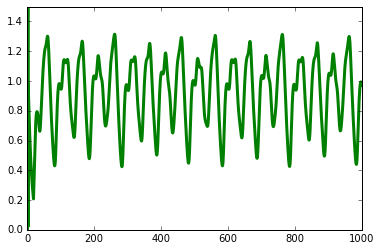

In [40]:
#First layer

#1st Input
nClusters=2
inputs1st=onlyInputs[:,0]
nsize=np.size(inputs1st)
xpts=np.linspace(0-d1+tiOriginal, nsize-d1+tiOriginal,nsize)
ypts=inputs1st
alldata = np.vstack((xpts, ypts))
u, u1, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    alldata, cntr1, 2, error=0.005, maxiter=1000)

#2nd Input
inputs2nd=onlyInputs[:,1]
xpts=np.linspace(0-d2+tiOriginal, nsize-d2+tiOriginal,nsize)
ypts=inputs2nd
alldata = np.vstack((xpts, ypts))
u, u2, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    alldata, cntr1, 2, error=0.005, maxiter=1000)

#3rd Input
inputs3rd=onlyInputs[:,2]
xpts=np.linspace(0-d3+tiOriginal, nsize-d3+tiOriginal,nsize)
ypts=inputs3rd
alldata = np.vstack((xpts, ypts))
u, u3, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    alldata, cntr1, 2, error=0.005, maxiter=1000)

#4th Input
inputs4th=onlyInputs[:,3]
xpts=np.linspace(0-d4+tiOriginal, nsize-d4+tiOriginal,nsize)
ypts=inputs4th
alldata = np.vstack((xpts, ypts))

membership1st = u1
membership2nd = u2
membership3rd = u3
membership4th = u3

## 2nd layer
pi1=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi2=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi3=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi4=np.multiply(np.multiply(membership1st[0,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))
pi5=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi6=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi7=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi8=np.multiply(np.multiply(membership1st[0,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))
pi9=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi10=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi11=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi12=np.multiply(np.multiply(membership1st[1,:],membership2nd[0,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))
pi13=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[0,:]))
pi14=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[0,:],membership4th[1,:]))
pi15=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[0,:]))
pi16=np.multiply(np.multiply(membership1st[1,:],membership2nd[1,:]),np.multiply(membership3rd[1,:],membership4th[1,:]))

## 3rd Layer
piSum=pi1+pi2+pi3+pi4+pi5+pi6+pi7+pi8+pi9+pi10+pi11+pi12+pi13+pi14+pi15+pi16

w1=np.divide(pi1,piSum)
w2=np.divide(pi2,piSum)
w3=np.divide(pi3,piSum)
w4=np.divide(pi4,piSum)
w5=np.divide(pi5,piSum)
w6=np.divide(pi6,piSum)
w7=np.divide(pi7,piSum)
w8=np.divide(pi8,piSum)
w9=np.divide(pi9,piSum)
w10=np.divide(pi10,piSum)
w11=np.divide(pi11,piSum)
w12=np.divide(pi12,piSum)
w13=np.divide(pi13,piSum)
w14=np.divide(pi14,piSum)
w15=np.divide(pi15,piSum)
w16=np.divide(pi16,piSum)

## 4th Layer
bias=np.ones((1,10000))
biasedInputs=np.vstack((onlyInputs.T,bias))
biasedInputs=biasedInputs.T

wf1=regresion1.predict(biasedInputs)
wf2=regresion2.predict(biasedInputs)
wf3=regresion3.predict(biasedInputs)
wf4=regresion4.predict(biasedInputs)
wf5=regresion5.predict(biasedInputs)
wf6=regresion6.predict(biasedInputs)
wf7=regresion7.predict(biasedInputs)
wf8=regresion8.predict(biasedInputs)
wf9=regresion9.predict(biasedInputs)
wf10=regresion10.predict(biasedInputs)
wf11=regresion11.predict(biasedInputs)
wf12=regresion12.predict(biasedInputs)
wf13=regresion13.predict(biasedInputs)
wf14=regresion14.predict(biasedInputs)
wf15=regresion15.predict(biasedInputs)
wf16=regresion16.predict(biasedInputs)

#Fifth Layer
finalOutput=wf1+wf2+wf3+wf4+wf5+wf6+wf7+wf8+wf9+wf10+wf11+wf12+wf13+wf14+wf15+wf16

#Printing the outcome
xpts=np.linspace(0, 1000,10000)
ypts=finalOutput
plt.plot(xpts,ypts,c='g', linewidth=3)
plt.ylim((0,1.5))
plt.show()

## Final comparison

We plot both original data and ANFIS data, and then we plot a zoomed part of the graph

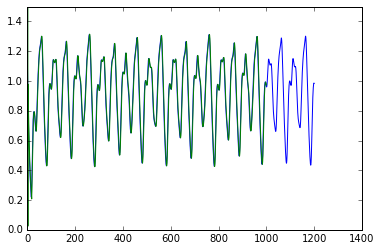

In [41]:
plt.plot(T,X,c='b', linewidth=1)
plt.plot(xpts,ypts,c='g', linewidth=1)
plt.ylim((0,1.5))
plt.show()

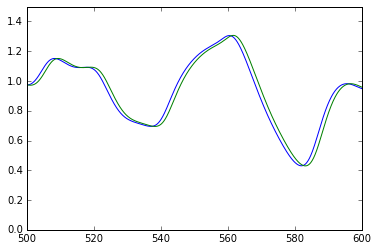

In [42]:
plt.plot(T,X,c='b', linewidth=1)
plt.plot(xpts,ypts,c='g', linewidth=1)
plt.ylim((0,1.5))
plt.xlim((500,600))
plt.show()

## Finding out the percentaje of error

In [47]:
porcentaje=(1-np.sum(ypts)/np.sum(X))*100
print porcentaje

16.9980296639
